In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet

from sklearn.metrics import mean_squared_error

dfs = [pd.read_csv('data_competition/Station_{}.csv'.format(i+1)) for i in range(10)]
dfs[0].head()

,Datum,Konsumtion,Temperatur,Nederbördsmängd,Vindriktning,Vindhastighet,Lufttryck,Daggpunktstemperatur,K2_regression
0,2013-01-01,101.254218,3.9,7.6,249.125000,3.525000,1009.579167,2.520833,108.273268
1,2013-01-02,107.111900,6.4,0.0,266.458333,7.191667,1012.695833,4.620833,92.933346
2,2013-01-03,102.091030,6.0,0.4,301.916667,5.833333,1018.775000,4.420833,95.387733
3,2013-01-04,107.948712,2.4,1.2,144.958333,1.141667,1026.116667,2.158333,117.477221
4,2013-01-05,104.601465,4.4,1.9,196.916667,1.833333,1022.154167,3.762500,105.205283


In [80]:
def prepare_for_prophet(df):
    #df = df.reset_index()
    df.columns = ['ds', 'y'] + list(df.columns[2:])
    df['ds'] = pd.to_datetime(df['ds'])
    return df

def divide_into_train_and_test(df):
    train = df[df.ds <= '2016-07-01']
    test = df[df.ds > '2016-07-01']
    return train, test

def train_prophet(df, regressor_list = None):
    train, test = divide_into_train_and_test(df)

    m = Prophet(growth = 'linear', 
             weekly_seasonality = False,
             daily_seasonality = False,
             yearly_seasonality = True)
    
    if regressor_list:
        for r in regressor_list:
            m.add_regressor(r, prior_scale=100, mode = 'multiplicative')
    
    m.fit(train)
    future= m.make_future_dataframe(periods=183)
    
    if regressor_list:
        for r in regressor_list:
            future[r] = df[r]
    
    forecast = m.predict(future)    
    return forecast, future, m

In [61]:
dfs = [prepare_for_prophet(df) for df in dfs]

In [62]:
results = pd.DataFrame()
rmsd=[]

for df in dfs:
    test = divide_into_train_and_test(df)[1]
    rmsd.append(mean_squared_error(test.K2_regression, test.y, squared=False))

results['RMSD_K2'] = rmsd
results

,RMSD_K2
0,16.244203
1,13.771645
2,15.692257
3,10.560060
4,11.810938
5,12.768318
6,11.105441
7,13.121964
8,11.004771
9,12.904813


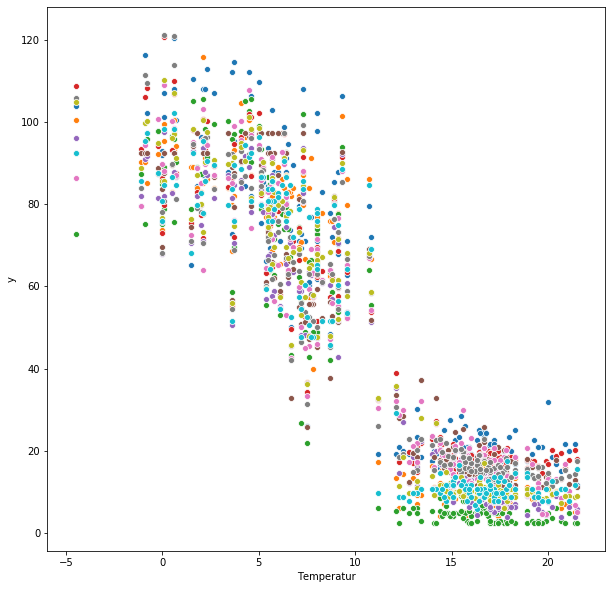

In [65]:
import seaborn as sns

#plt.figure(figsize=(30,30))
plt.figure(figsize=(10,10))
for i, df in enumerate(dfs):
    #plt.subplot(5, 2, i+1)
    sns.scatterplot(x='Temperatur', y='y', data=divide_into_train_and_test(df)[1])
    #sns.scatterplot(x='Temperatur', y='K2_regression', data=divide_into_train_and_test(df)[1])

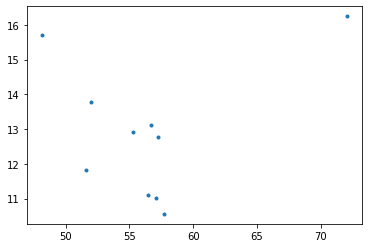

In [64]:
means = [df.y.mean() for df in dfs]

plt.plot(means, rmsd, '.')

In [46]:
dfs[0].dtypes

ds                      datetime64[ns]
y                              float64
Temperatur                     float64
Nederbördsmängd                float64
Vindriktning                   float64
Vindhastighet                  float64
Lufttryck                      float64
Daggpunktstemperatur           float64
K2_regression                  float64
dtype: object

In [66]:
results

,RMSD_K2
0,16.244203
1,13.771645
2,15.692257
3,10.560060
4,11.810938
5,12.768318
6,11.105441
7,13.121964
8,11.004771
9,12.904813


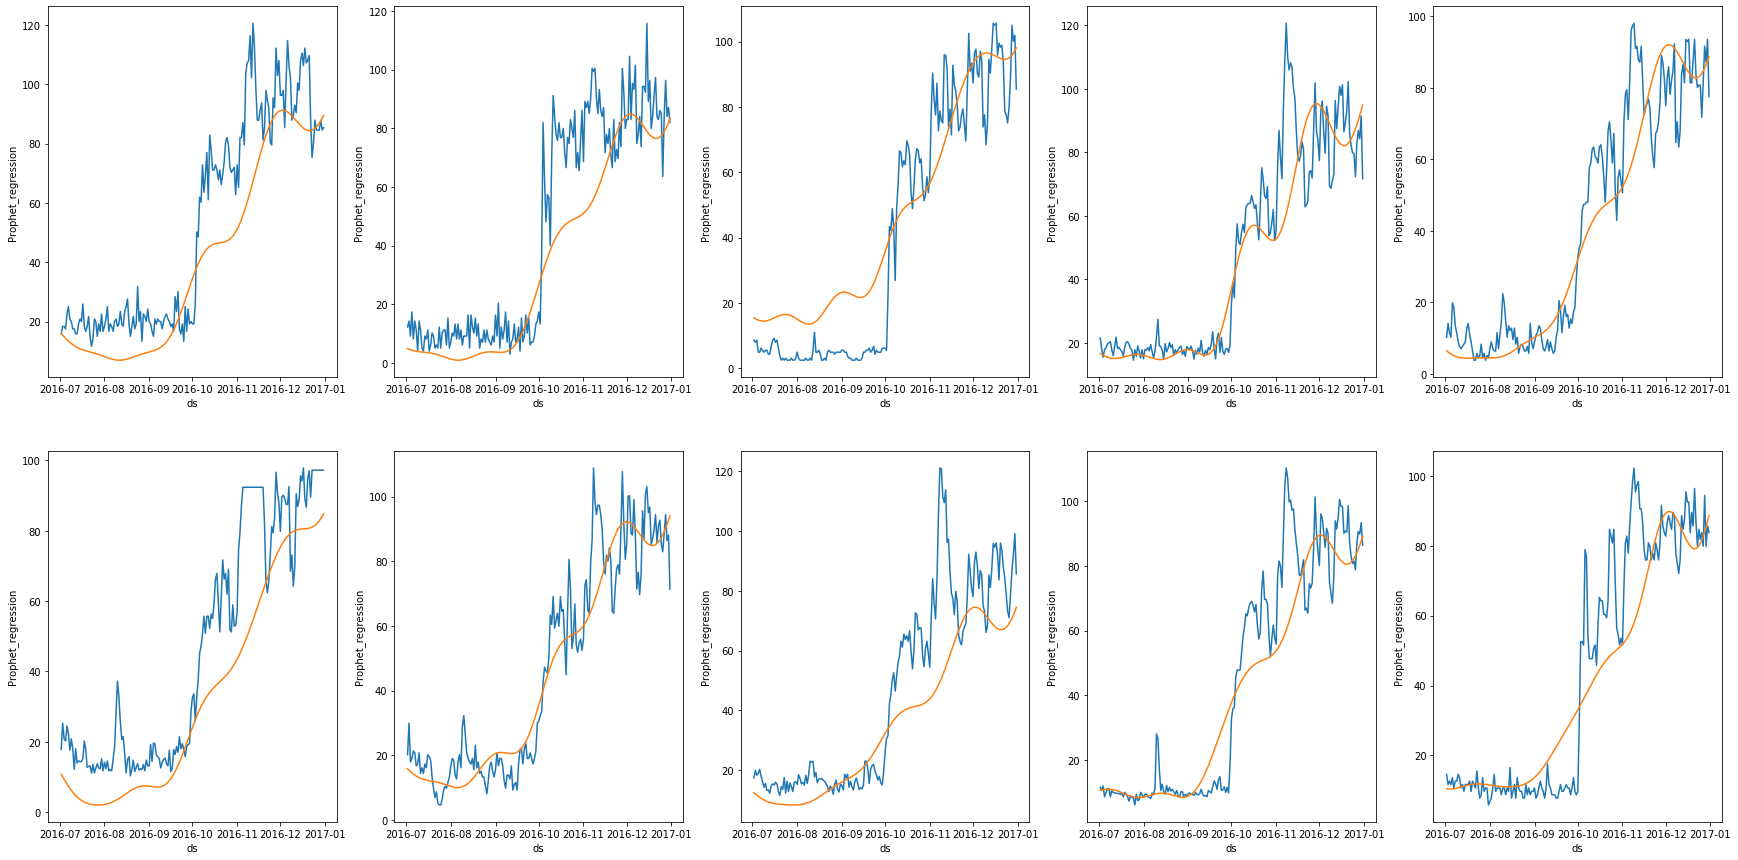

In [81]:
rmsd = []
plt.figure(figsize=(30,15))
for i, df in enumerate(dfs):
    forecast, future, m = train_prophet(df)
    df['Prophet_regression'] = forecast.yhat
    test = divide_into_train_and_test(df)[1]
    rmsd.append(round(mean_squared_error(test['Prophet_regression'], test.y, squared=False), 2))
    #print_errors(forecast.yhat[-365:], test.y)
    plt.subplot(2,5,i+1)
    sns.lineplot(x = 'ds', y = 'y', data=test)
    sns.lineplot(x = 'ds', y = 'Prophet_regression', data=test)
    
results['RMSD_Prophet'] = rmsd

In [82]:
results

,RMSD_K2,RMSD_Prophet
0,16.244203,17.42
1,13.771645,17.27
2,15.692257,14.38
3,10.560060,12.91
4,11.810938,11.63
5,12.768318,17.54
6,11.105441,10.13
7,13.121964,18.02
8,11.004771,12.94
9,12.904813,13.84


In [71]:
dfs[0].columns

Index(['ds', 'y', 'Temperatur', 'Nederbördsmängd', 'Vindriktning',
       'Vindhastighet', 'Lufttryck', 'Daggpunktstemperatur', 'K2_regression',
       'Prophet_regression'],
      dtype='object')

In [75]:
#dfs[0].isna().sum()
dfs[0]['Temperatur'].isnull().any()

False

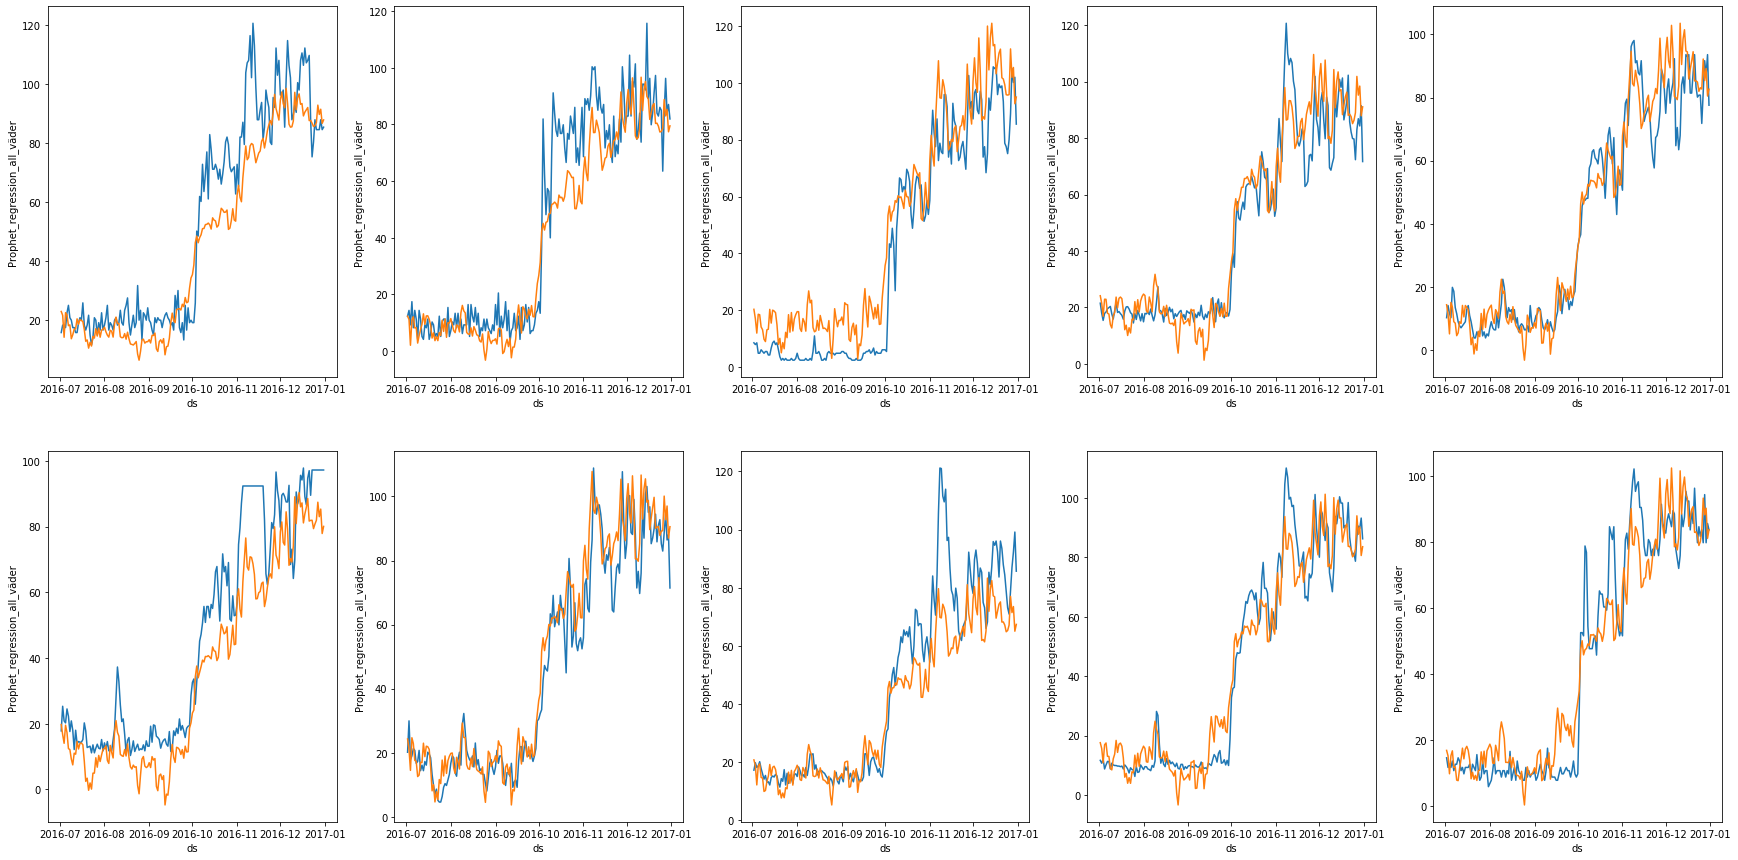

In [83]:
rmsd = []
var_list = ['Temperatur', 'Nederbördsmängd', 'Vindriktning', 'Vindhastighet', 'Lufttryck', 'Daggpunktstemperatur']
plt.figure(figsize=(30,15))
for i, df in enumerate(dfs):
    forecast, future, m = train_prophet(df, regressor_list= var_list)#[v2 for v2 in var_list if v2!=v])
    df['Prophet_regression_all_väder'] = forecast.yhat
    test = divide_into_train_and_test(df)[1]
    rmsd.append(round(mean_squared_error(test['Prophet_regression_all_väder'], test.y, squared=False), 2))
    #print_errors(forecast.yhat[-365:], test.y)
    plt.subplot(2,5,i+1)
    sns.lineplot(x = 'ds', y = 'y', data=test)
    sns.lineplot(x = 'ds', y = 'Prophet_regression_all_väder', data=test)
    
results['RMSD_Prophet_all_väder'] = rmsd

In [89]:

var_list = ['Temperatur', 'Nederbördsmängd', 'Vindriktning', 'Vindhastighet', 'Lufttryck', 'Daggpunktstemperatur']

for v in var_list:
    print(v)
    rmsd = []
    for i, df in enumerate(dfs):
        forecast, future, m = train_prophet(df, regressor_list= [v])#[v2 for v2 in var_list if v2!=v])
        df['Prophet_regression_'+v] = forecast.yhat
        test = divide_into_train_and_test(df)[1]
        rmsd.append(round(mean_squared_error(test['Prophet_regression_'+v], test.y, squared=False), 2))

    results['RMSD_Prophet_'+v] = rmsd

Temperatur
Nederbördsmängd
Vindriktning
Vindhastighet
Lufttryck
Daggpunktstemperatur


In [91]:
results.mean()

RMSD_K2                              12.898441
RMSD_Prophet                         14.608000
RMSD_Prophet_all_väder               11.115000
RMSD_Prophet_Temperatur              11.399000
RMSD_Prophet_Nederbördsmängd         14.599000
RMSD_Prophet_Vindriktning            14.567000
RMSD_Prophet_Vindhastighet           14.797000
RMSD_Prophet_Lufttryck               14.203000
RMSD_Prophet_Daggpunktstemperatur    11.795000
dtype: float64